In [1]:
#!/usr/bin/env python
import math
import random
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2
import re

from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend

#Load all our images into separate lists by first making a method that takes
#the path and returns a list of pictures (their file paths)
PATH_PICS_FOLDER = "/home/fizzer/353comp/src/imitation_pics/"

def pic_file_list(folder_path):
    pic_path_list = []

    for r,d,f in os.walk(folder_path):
        for file in f:
            if '.png' in file:
                filePath = os.path.join(r,file)
                pic_path_list.append(filePath)

    return pic_path_list

backward_pic_list = pic_file_list(PATH_PICS_FOLDER + "backward")
forward_pic_list = pic_file_list(PATH_PICS_FOLDER + "forward")
left_pic_list = pic_file_list(PATH_PICS_FOLDER + "left")
right_pic_list = pic_file_list(PATH_PICS_FOLDER + "right")

total_pic_list = []
total_pic_list.extend(backward_pic_list + forward_pic_list + left_pic_list + right_pic_list)

#pix = cv2.imread(total_pic_list[0])
#cv2.imshow("test",pix)
#cv2.waitKey(0)

print("Number of images loaded:  {:}".format(len(total_pic_list)))


Using TensorFlow backend.
Number of images loaded:  32123


In [2]:
#Now we make our X_train and Y_train dataset, so first we need to shuffle.
random.shuffle(forward_pic_list) 
random.shuffle(backward_pic_list)
random.shuffle(left_pic_list)
random.shuffle(right_pic_list)

PICS_TO_USE = 5000
training_pic_list = []
training_pic_list.extend(forward_pic_list[:PICS_TO_USE] + backward_pic_list + left_pic_list + right_pic_list[:PICS_TO_USE])
random.shuffle(training_pic_list)

X_train = []
Y_train = []

for img in training_pic_list:

    frame_pic = cv2.imread(img)
    X_train.append(frame_pic)

    if img in forward_pic_list:
        Y_train.append([1,0,0,0])
    elif img in backward_pic_list:
         Y_train.append([0,1,0,0])
    elif img in left_pic_list:
         Y_train.append([0,0,1,0])
    elif img in right_pic_list:
         Y_train.append([0,0,0,1])

#Normalize
X_train = np.array(X_train)
X_train_normed = X_train / 255
Y_train = np.array(Y_train)

print(Y_train.shape)


(12804, 4)


In [ ]:
def display_image(index):
    plt.imshow(X_train[index])
    caption = ("Y (action) = " + str(Y_train[index]))
    plt.text(0.5,0.5,caption, color = 'red', fontsize=18, horizontalalignment='left', verticalalignment ='bottom')

display_image(1700)

In [3]:
loaded_model = models.load_model("/home/fizzer/Comp_CNN/new_model_driver_cnn.h5")
loaded_model._make_predict_function()

loaded_model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#Now we build the model (or load one above)

conv_model = models.Sequential()

conv_model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(480,640,3)))
conv_model.add(layers.MaxPooling2D((2,2)))
conv_model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(pool_size=(2,2)))
conv_model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(128, activation='relu'))

num_possibilities = 4
conv_model.add(layers.Dense(num_possibilities,activation = 'softmax'))

conv_model.summary()

In [ ]:
loaded_model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])

Train on 8706 samples, validate on 4098 samples
Epoch 1/15
8706/8706 [==============================] - 2643s 304ms/step - loss: 0.1796 - acc: 0.9392 - val_loss: 0.1933 - val_acc: 0.9383
Epoch 2/15
8706/8706 [==============================] - 2600s 299ms/step - loss: 0.1507 - acc: 0.9445 - val_loss: 0.1627 - val_acc: 0.9468
Epoch 3/15
8706/8706 [==============================] - 2607s 299ms/step - loss: 0.1384 - acc: 0.9512 - val_loss: 0.3144 - val_acc: 0.9287
Epoch 4/15
8706/8706 [==============================] - 2601s 299ms/step - loss: 0.1278 - acc: 0.9526 - val_loss: 0.1633 - val_acc: 0.9473
Epoch 5/15
8706/8706 [==============================] - 2597s 298ms/step - loss: 0.1138 - acc: 0.9607 - val_loss: 0.1716 - val_acc: 0.9431
Epoch 6/15
8706/8706 [==============================] - 2595s 298ms/step - loss: 0.1040 - acc: 0.9638 - val_loss: 0.2683 - val_acc: 0.9366
Epoch 7/15
8706/8706 [==============================] - 2602s 299ms/step - loss: 0.0994 - acc: 0.9667 - val_loss: 0.16

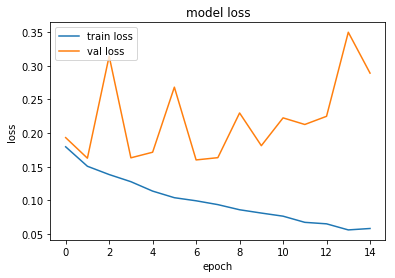

In [4]:
VALIDATION_SPLIT = 0.32
history_conv = loaded_model.fit(X_train_normed,Y_train,
                              batch_size=16,
                              epochs=15,
                              validation_split=VALIDATION_SPLIT)

#plot loss vs epoch
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

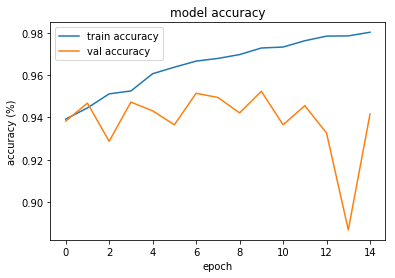

In [5]:
#plot accuracy % vs epoch
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [6]:
def displayResult(index):
    img = X_train_normed[index]
    img_with_top = np.expand_dims(img,axis=0)
    
    y_predict = conv_model.predict(img_with_top)
    print y_predict
        
    plt.imshow(X_train[index])

    caption = ("Actual: {}\nPredicted: {}".
                format(Y_train[index], y_predict))
    plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')
    
    return y_predict

displayResult(999)

NameError: global name 'conv_model' is not defined

In [7]:
loaded_model.save("new_trained_model_driver_cnn_bad?_overnight.h5")
print("saved model")

#Note: to load module use load_model(filepath)

saved model


In [ ]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [11]:
split = int(round(0.68*len(X_train))*VALIDATION_SPLIT)
print split

labels = ["Forward", "Backward", "Left", "Right"]
y_gnd_truth = Y_train[split:].argmax(axis=1)
y_pred_raw = loaded_model.predict(X_train_normed[split:])
y_pred = y_pred_raw.argmax(axis=1)

matrix = metrics.confusion_matrix(y_gnd_truth, y_pred)

df_cm = pd.DataFrame(matrix, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
#plt.matshow(matrix)

2786


KeyboardInterrupt: 